In [1]:
!pip install datasets torch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# Text Classification

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. Chances are that your email program's spam filter is using text classification to protect your inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which (as we saw in <<chapter_introduction>>) aims to identify the polarity of a given text. For example, a company like Tesla might analyze Twitter posts like the one in <<tesla-tweet>> to determine whether people like its new car roofs or not.

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="images/chapter02_tweet.png" id="tesla-tweet"/>

Now imagine that you are a data scientist who needs to build a system that can automatically identify emotional states such as "anger" or "joy" that people express about your company's product on Twitter. In this chapter, we'll tackle this task using a variant of BERT called DistilBERT.footnote:[V. Sanh et al., ["DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter"](https://arxiv.org/abs/1910.01108), (2019).] The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A _checkpoint_ corresponds to the set of weights that are loaded into a given transformer architecture.

This will also be our first encounter with three of the core libraries from the Hugging Face ecosystem: image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers. As shown in  <<hf-libraries>>, these libraries will allow us to quickly go from raw text to a fine-tuned model that can be used for inference on new tweets. So, in the spirit of Optimus Prime, let's dive in, "transform, and roll out!"footnote:[Optimus Prime is the leader of a race of robots in the popular Transformers franchise for children (and for those who are young at heart!).]

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="images/chapter02_hf-libraries.png" id="hf-libraries"/>

## The Dataset

To build our emotion detector we'll use a great dataset from an article that explored how emotions are represented in English Twitter messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," _Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing_ (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.] Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

Let's load the `emotion` dataset with the `load_dataset()` function:

In [2]:
# hide_output
from datasets import load_dataset
import numpy as np

emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/ec2-user/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

If we look inside our `emotions` object:

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [5]:
len(train_ds)

16000

or access a single example by its index:

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [7]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that image:images/logo.png[hf,13,13] Datasets is based on [_Apache Arrow_](https://arrow.apache.org/), which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [10]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


Now that we've seen how to load and inspect data with image:images/logo.png[hf,13,13] Datasets, let's do a few sanity checks about the content of our tweets.

### From Datasets to DataFrames

Although image:images/logo.png[hf,13,13] Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, image:images/logo.png[hf,13,13] Datasets provides a `set_format()` method that allows us to change the _output format_ of the `Dataset`. Note that this does not change the underlying _data format_ (which is an Arrow table), and you can switch to another format later if needed:

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:

In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Before diving into building a classifier, let's take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post ["A Recipe for Training Neural Networks"](https://karpathy.github.io/2019/04/25/recipe), becoming "one with the data" is an essential step for training great models!

### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one. 

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

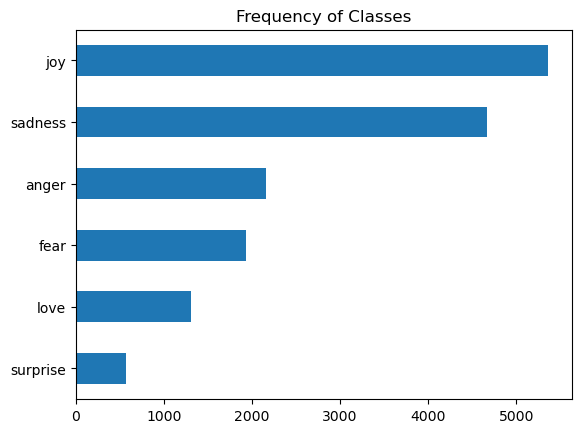

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

* Randomly oversample the minority class.
* Randomly undersample the majority class.
* Gather more labeled data from the underrepresented classes.

To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the [Imbalanced-learn library](https://imbalanced-learn.org/stable/). Just make sure that you don't apply sampling methods _before_ creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

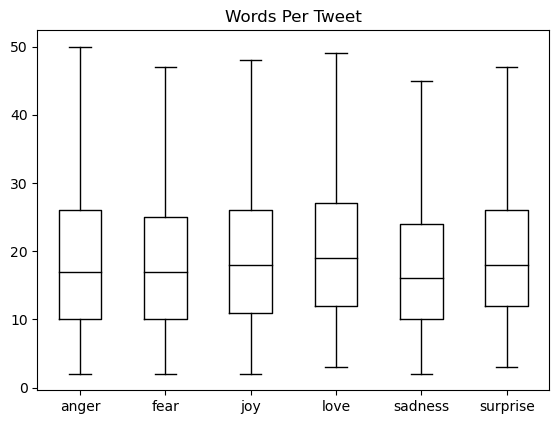

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue. 

Let's now figure out how we can convert these raw texts into a format suitable for image:images/logo.png[hf,13,13] Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the `DataFrame` format anymore: 

In [15]:
emotions.reset_format()

## From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been _tokenized_ and _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. image:images/logo.png[hf,13,13] Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [17]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The `AutoTokenizer` class belongs to a larger set of ["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto) whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> note: When you run the `AutoTokenizer.from_pretrained()` method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at _~/.cache/huggingface/_.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [18]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We can observe three things here. First, some special `[CLS]` and `[SEP]` tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The `##` prefix in `##izing` and `##p` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The `AutoTokenizer` class has a `convert_tokens_to_string()` method for doing just that, so let's apply it to our tokens:

In [20]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [21]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [22]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [23]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

> warning: When using pretrained models, it is _really_ important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [24]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [25]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [26]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. <<attention-mask>> provides a visual explanation of how the input IDs and attention masks are padded.

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="images/chapter02_attention-mask.png" id="attention-mask"/> 

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [27]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-7a6eff155540e100.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-68da488fc8cc68f8.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-88467d7169a76d6e.arrow


By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [28]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in <<encoder-tuning>>. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="images/chapter02_encoder-fine-tuning.png" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from image:images/logo.png[hf,13,13] Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [30]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

## Training the model -- Option 1: SageMaker Training Job

#### Note: Run this option only if you have access to a ml.g4dn.xlarge instance!

In [31]:
!pip install -U sagemaker

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.3/743.3 kB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.148.0-py2.py3-none-any.whl size=998497 sha256=04bc252e52718539a7b50f8352d81856bc3baa7425b3fc1eb17aa6d51159d625
  Stored in directory: /home/ec2-user/.cache/pip/wheels/10/c3/61/1cec52e54a229c15ddd0a8dae1f8978b55c076bea1872daa77
Successfully built sagemaker
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.2.0:
      Successfully uninstalled cloudpic

In [32]:
import sagemaker.huggingface
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::905847418383:role/service-role/AmazonSageMaker-ExecutionRole-20230127T203433
sagemaker bucket: sagemaker-us-east-1-905847418383
sagemaker session region: us-east-1


In [33]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()

s3_prefix = 'samples/datasets/02_classification'

train_dataset=emotions_encoded["train"]
eval_dataset=emotions_encoded["validation"]

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk("./train")

# save eval_dataset to s3
eval_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/validation'
eval_dataset.save_to_disk("./validation")

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
! aws s3 cp train/ $training_input_path --recursive

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
upload: train/dataset_info.json to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/train/dataset_info.json
upload: train/state.json to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/train/state.json
upload: train/data-00000-of-00001.arrow to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/train/data-00000-of-00001.arrow


In [35]:
! aws s3 cp validation/ $eval_input_path --recursive

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
upload: validation/dataset_info.json to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/validation/dataset_info.json
upload: validation/state.json to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/validation/state.json
upload: validation/data-00000-of-00001.arrow to s3://sagemaker-us-east-1-905847418383/samples/datasets/02_classification/validation/data-00000-of-00001.arrow


In [36]:
from sagemaker.huggingface import HuggingFace
import time

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

# hyperparameters, which are passed into the training job
hyperparameters={'model_id': model_ckpt,
                 'num_train_epochs': 2,
                 'learning_rate': 2e-5,
                 'per_device_train_batch_size': batch_size,
                 'per_device_eval_batch_size': batch_size,
                 'learning_rate': 2e-5,
                 'weight_decay': 0.01,
                 'evaluation_strategy': "epoch",
                 'disable_tqdm': False,
                 'logging_steps': logging_steps,
                }


In [37]:
# define Training Job Name 
base_job_name = "nlp-emotion-classificaton"

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',                   # fine-tuning script used in training jon
    source_dir           = './scripts',                  # directory where fine-tuning script is stored
    instance_type        = 'ml.g4dn.xlarge',              # instances type used for the training job
    instance_count       = 1,                            # the number of instances used for training
    base_job_name        = base_job_name,                # the name of the training job
    role                 = role,                         # IAM role used in training job to access AWS ressources, e.g. Amazon S3
    transformers_version = '4.26',                       # the transformers version used in the training job
    pytorch_version      = '1.13',                       # the pytorch_version version used in the training job
    py_version           = 'py39',                       # the python version used in the training job
    hyperparameters      = hyperparameters,              # the hyperparameter used for running the training job
)

In [38]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': training_input_path,
    'test': eval_input_path
}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(data, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: nlp-emotion-classificaton-2023-04-22-05-59-14-879


Using provided s3_resource
2023-04-22 05:59:15 Starting - Starting the training job...
2023-04-22 05:59:30 Starting - Preparing the instances for training......
2023-04-22 06:00:21 Downloading - Downloading input data...
2023-04-22 06:00:46 Training - Downloading the training image.....................
2023-04-22 06:04:37 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-22 06:04:46,964 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-22 06:04:46,984 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-04-22 06:04:46,998 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-22 06:04:47,002 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-22 06:04:47,264 sagemaker-training-toolkit INF

In [39]:
predictor = huggingface_estimator.deploy(1, "ml.g4dn.xlarge")

INFO:sagemaker:Creating model with name: nlp-emotion-classificaton-2023-04-22-06-12-52-800
INFO:sagemaker:Creating endpoint-config with name nlp-emotion-classificaton-2023-04-22-06-12-52-800
INFO:sagemaker:Creating endpoint with name nlp-emotion-classificaton-2023-04-22-06-12-52-800


-----------!

Now we can test our model with a single tweet

In [83]:
custom_tweet = {"inputs" : "I saw a movie today and it was really good."}
predictor.predict(custom_tweet)

[{'label': 'joy', 'score': 0.9614872336387634}]

## Training the model -- Option 2: Locally in Notebook instance

### Loading a pretrained model


The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. We use the AutoModelForSequenceClassification model class. The AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [89]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to("cpu"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

To define the training parameters, we use the TrainingArguments class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is output_dir, which is where all the artifacts from training are stored. Here is an example of TrainingArguments in all its glory:

In [92]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the Trainer:

In [93]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [94]:
trainer.train()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818900,0.321319,0.904000,0.900439
2,0.255500,0.222489,0.927000,0.926939


TrainOutput(global_step=500, training_loss=0.5372138214111328, metrics={'train_runtime': 883.7965, 'train_samples_per_second': 36.207, 'train_steps_per_second': 0.566, 'total_flos': 720342861696000.0, 'train_loss': 0.5372138214111328, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict("I saw a movie today and it was really good.")

## Model evaluation
Now we know that the endpoint works it is time to evaluate our model. For that we use the model to predict the emotions of the texts in the validation data set and compare them to the ground truth.

First we determine the model predictions:

**Option 1 with SM Endpoint:**

In [84]:
y_preds = []
for i, x in enumerate(emotions_encoded["validation"]):
    pred_sentiment = predictor.predict({"inputs": x["text"]})
    y_preds.append(emotions["train"].features["label"].str2int(pred_sentiment[0]["label"]))

**Option 2 with locallly trained model**

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=1)

Then we retrieve the ground truth from the validation data set and create a confusion matrix

In [85]:
y_valid = np.array(emotions_encoded["validation"]["label"])

In [86]:
labels = emotions["train"].features["label"].names

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

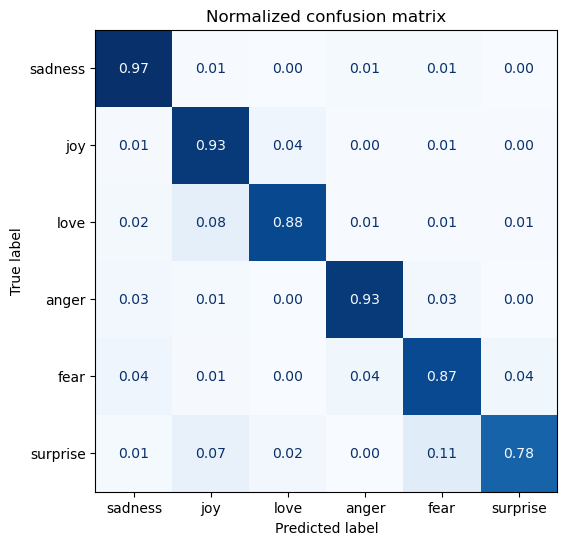

In [88]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is close to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

## Conclusion

Congratulations, you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses. 

However, this is just the first step in building a real-world application with transformer models, and we have a lot more ground to cover. Here's a list of challenges you're likely to experience in your NLP journey:

My boss wants my model in production yesterday!::
In most applications, your model doesn't just sit somewhere gathering dust - you want to make sure it's serving predictions! When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the [documentation](https://api-inference.huggingface.co/docs/python/html/index.html) of the Inference API if you want to learn more. 

My users want faster predictions!::
We've already seen one approach to this problem: using DistilBERT. In <<chapter_compression>> we'll dive into knowledge distillation (the process by which DistilBERT was created), along with other tricks to speed up your transformer models.


Can your model also do X?::
As we've alluded to in this chapter, transformers are extremely versatile. In the rest of the book we will be exploring a range of tasks, like question answering and named entity recognition, all using the same basic architecture.

None of my texts are in English!::
It turns out that transformers also come in a multilingual variety, and we'll use them in <<chapter_ner>> to tackle several languages at once.

I don't have any labels!::
If there is very little labeled data available, fine-tuning may not be an option. In <<chapter_fewlabels>>, we'll explore some techniques to deal with this situation.

Now that we've seen what's involved in training and sharing a transformer, in the next chapter we'll explore implementing our very own transformer model from scratch.